https://www.youtube.com/watch?v=_eSGWNqKeeY

# 간단한 EDA!

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import re
import torch

In [2]:
path = "./data"
train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")
print(' Done.')

 Done.


In [3]:
# Display the first five rows of the table.
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 불용어 제거하여 corpus만들기

In [4]:
# 불용어 제거: @를 포함한 태그 문구 삭제, 링크 주소 삭제
docs = [[word for word in sent if not any('http')] for sent in train_df.text]

In [5]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

In [6]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower()[:4] not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = ['http']

In [7]:
#전처리 적용(부호 제거해 주고 소문자로 바꿔주고 불용어(홈페이지 주소)도 제거)
train_df['text'] = train_df['text'].apply(alpha_num)
train_df['text'] = train_df['text'].str.lower()
train_df['text'] = train_df['text'].apply(remove_stopwords)

In [8]:
[i for i in train_df.tail(1).text]

['the latest more homes razed by northern california wildfire abc news']

### 누락값 처리

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
# 누락값의 개수
np.count_nonzero(train_df.keyword.isnull())

61

In [11]:
# 누락값이 아닌 자료 개수
train_df.keyword.count()

7552

In [12]:
# keyword 없는 행이 전체 자료들에서 차지하는 비중이 작으므로 삭제
train_df = train_df[train_df['keyword'].notna()]
train_df.shape

(7552, 5)

단어별 재난 연관률

In [13]:
labels = pd.DataFrame(train_df.groupby('keyword')['target'].mean())

In [14]:
labels = labels.sort_values(by='target', ascending=False)
labels.head()

,target
keyword,
debris,1.000000
wreckage,1.000000
derailment,1.000000
outbreak,0.975000
oil%20spill,0.973684


In [15]:
labels.shape

(221, 1)

해당 단어 등장 대비 실제 재해 트윗인 비율을 기준으로 221개의 keyword 중, 상위 5개 단어를 뽑아봄: 특히 debris, wreckage, derailment 이 3개 단어는 등장했을 경우 모두 재난 상황을 지칭한 경우였음

#### 재난 상황 트윗 임의로 10개 뽑아 관찰

In [16]:
import textwrap
import random

# Wrap text to 80 characters
wrapper = textwrap.TextWrapper(width = 80)

# filter to just the 'Disaster' comments
disaster_examples = train_df.query('target == 1')['text']

# Randomly choose some examples
for i in range(10):
    j = random.choice(disaster_examples.index)
    print('')
    print(wrapper.fill(disaster_examples[j]))
    print('')


where are the protests the riots the burning buildings how come you dont see any
of that crap happening when


families to sue over legionnaires more than 40 families affected by the fatal
outbreak of legionnaires disea


1 million bail for man accused of shooting at fife police aug 5 816 pm et


christian attacked by muslims at the temple mount after waving israeli flag via
pamela geller


families to sue over legionnaires more than 40 families affected by the fatal
outbreak of legio muhamadjabal


fatality


still rioting in a couple of hours left until i have to be up for class


more homes razed by northern calif wildfire sandiego


lightning causes six new fires on vancouverisland


kindermorgan gas explosion



In [17]:
# What percentage of the comments are disaster tweets?
total_tweets = len(train_df)
num_disasters = len(train_df.query('target == 1'))

print('{:,}개의 트윗 중 {:,}개는 재난 관련 트윗임({:.2%}).'.format(total_tweets, num_disasters, num_disasters/total_tweets))

7,552개의 트윗 중 3,229개는 재난 관련 트윗임(42.76%).


keyword == NaN인 행들을 날린 train_df는 재난 트윗과 재난이 아닌 트윗이 꽤 균형 있게 존재한다.

다양한 python format 형식들: https://www.w3schools.com/python/ref_string_format.asp

In [18]:
# 전처리된 train_df의 text들 중 가장 긴 tweet의 단어 개수와 가장 짧은 단어 개수 출력
total_mx = max([len(length) for length in train_df.text])
total_mn = min([len(length) for length in train_df.text])
disaster_mx = max([len(length) for length in train_df.query('target == 1')])
disaster_mn = min([len(length) for length in train_df.query('target == 1')])

print('전체 tweets 중 최대 길이: {:>,}, 최소 길이 {:>,} \n재해 tweets 중 최대 길이: {}, 최소 길이 {}'.format(total_mx, total_mn, disaster_mx, disaster_mn))

전체 tweets 중 최대 길이: 143, 최소 길이 5 
재해 tweets 중 최대 길이: 8, 최소 길이 2


# BERT Input Length Limitation

In [19]:
from transformers import BertTokenizer

print("Load Bert_Tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Load Bert_Tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertTokenizer이 어떻게 작동되는지 살펴보기

In [20]:
# 첫 번째 텍스트 꺼내오기
sample_text = train_df.iloc[0].text

# Run the tokenizer to count up the number of tokens. The tokenizer will split the text into words, punctuations and subwords as needed
tokens = tokenizer.tokenize(sample_text)

print('train_df의 첫 번째 text에는 {:,}개의 WordPiece Tokens를 가지고 있다'.format(len(tokens)))
print('\nOriginal Text:\n')
print(wrapper.fill(sample_text))

train_df의 첫 번째 text에는 7개의 WordPiece Tokens를 가지고 있다

Original Text:

bbcmtd wholesale markets ablaze


In [21]:
# 토큰 리스트 출력
print('==== Tokens ====\n')
print(wrapper.fill(str(' '.join(tokens))))
print('')

==== Tokens ====

bbc ##mt ##d wholesale markets ab ##laze



##으로 끊긴 부분은 subword로 끊어 학습한 것

### 모든 트윗들 Bert 이용하여 Tokenize

In [22]:
import numpy as np

# 모든 문장 토크나이징 하고 kewwords에 따라 분류하기
input_keywords  = []

# 각 트윗의 토큰 개수 기록
token_len = []

print('Tokenizing Tweets...')

# 각 트윗 마다...
for tweet in train_df.text:
    # 진행 상황
    if ((len(input_keywords) % 100) == 0):
        print(' Read {:,} tweets.'.format(len(input_keywords)))
    
    # encode는 1)트윗을 토크나이징하고, 2)[CLS]토큰을 시작 부분에, [SEP]토큰을 마지막 부분에 추가하고, 3)토큰을 해당 keyword에 매칭
    encoded_sent = tokenizer.encode(tweet, add_special_tokens = True) # add_special_tokens: [CLS]와 [SEP]추가'
    
    # encoded된 트윗을 리스트에 넣기
    input_keywords.append(encoded_sent)
    
    # 각 트윗의 토큰 개수 기록
    token_len.append(len(encoded_sent))

print('DONE.')
print('{:>10} tweets'.format(len(input_keywords)))



Tokenizing Tweets...
 Read 0 tweets.
 Read 100 tweets.
 Read 200 tweets.
 Read 300 tweets.
 Read 400 tweets.
 Read 500 tweets.
 Read 600 tweets.
 Read 700 tweets.
 Read 800 tweets.
 Read 900 tweets.
 Read 1,000 tweets.
 Read 1,100 tweets.
 Read 1,200 tweets.
 Read 1,300 tweets.
 Read 1,400 tweets.
 Read 1,500 tweets.
 Read 1,600 tweets.
 Read 1,700 tweets.
 Read 1,800 tweets.
 Read 1,900 tweets.
 Read 2,000 tweets.
 Read 2,100 tweets.
 Read 2,200 tweets.
 Read 2,300 tweets.
 Read 2,400 tweets.
 Read 2,500 tweets.
 Read 2,600 tweets.
 Read 2,700 tweets.
 Read 2,800 tweets.
 Read 2,900 tweets.
 Read 3,000 tweets.
 Read 3,100 tweets.
 Read 3,200 tweets.
 Read 3,300 tweets.
 Read 3,400 tweets.
 Read 3,500 tweets.
 Read 3,600 tweets.
 Read 3,700 tweets.
 Read 3,800 tweets.
 Read 3,900 tweets.
 Read 4,000 tweets.
 Read 4,100 tweets.
 Read 4,200 tweets.
 Read 4,300 tweets.
 Read 4,400 tweets.
 Read 4,500 tweets.
 Read 4,600 tweets.
 Read 4,700 tweets.
 Read 4,800 tweets.
 Read 4,900 tweets.
 

In [23]:
# 토큰나이징 된 train_df의 tweet들 중 가장 긴 tweet의 단어 개수와 가장 짧은 단어 개수 출력

print('전체 tweets 중 토큰 최대 개수: {:>,}, 최소 개수: {:>,}, 중간값: {:.0f}'.format(max(token_len), min(token_len), np.median(token_len)))

전체 tweets 중 토큰 최대 개수: 55, 최소 개수: 3, 중간값: 20


### 토큰 길이 분포에 따른 시각화

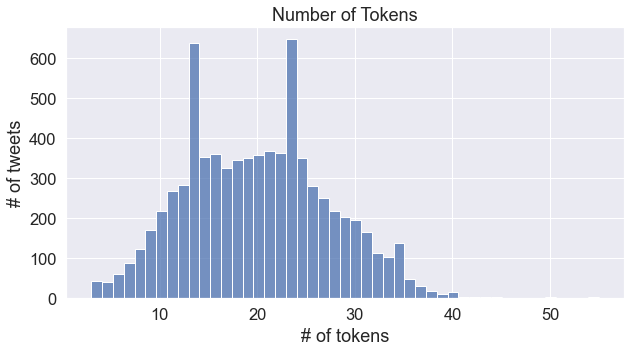

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px


sns.set(style = 'darkgrid')

# 플롯 크기랑 폰트 사이즈 키우기
sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (10, 5)

# 트윗 토큰 개수에 따른 시각화
sns.histplot(token_len, kde = False)
plt.title("Number of Tokens")
plt.xlabel('# of tokens')
plt.ylabel('# of tweets')
plt.show()

In [25]:
# 트윗의 길이와 재난 관련 트윗일 확률 간에 상관 관계가 있을까?



### 트윗들 padding하기

In [26]:
### 트윗들 padding하기


from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 55 #트윗당 최대 토큰 개수로 맞춰서 누락되는 토큰 아예 없애기

print('\nPadding all tweets to %d values...' % MAX_LEN)
print('\nPadding Token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# input_keywords에 담긴 트윗당 토큰들을 0으로 채워넣어 Max_len 크기로 패딩하기
input_keywords = pad_sequences(input_keywords, maxlen = MAX_LEN, dtype = 'long', value = 0, truncating = 'post', padding = 'post')
print('\nDONE.')


Padding all tweets to 55 values...

Padding Token: "[PAD]", ID: 0

DONE.


attention_masks로 패딩값과 패딩 아닌 값들 구분

In [27]:
attention_masks = []

for sent in input_keywords:
    att_mask = [int(token_id>0) for token_id in sent]

    attention_masks.append(att_mask)

---

학습용 데이터 90%와 검증용 데이터 10%로 나누기

In [28]:
from sklearn.model_selection import train_test_split

# 훈련 90% 검증 10%로 나누기
train_inputs, validation_inputs = train_test_split(input_keywords, random_state = 2018, test_size = 0.1)

# 마스크도 나누어 주기
train_masks, validation_masks = train_test_split(attention_masks, random_state = 2018, test_size = 0.1)

BERT 모델은 넘파이보다 파이토치 텐서를 입력값으로 받으므로 파이토치로 변환

In [31]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

데이터셋 iterator만들어 메모리 절약

In [32]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# 훈련 데이터를 위한 data_loader
train_data= TensorDataset(train_inputs, train_masks)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

In [33]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels = 2, #이진 분류이므로
    output_attentions = False,
    output_hidden_states = False
)

# model.cuda()  #GPU로 모델 돌릴거라고 말해줌

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader)* epochs

# learning rate scheduler 만들기
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

정확도 측정 위한 helper 함수 정의

import numpy as np
def 

device = torch.device('cpu')

import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('=== Epochs {:} / {:} ==='.format(epoch_i+i, epochs))
    print("Training...")

    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            # 진행상황
            print(' Batch  {:>} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        # b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids = None, attention_masks = b_input_mask) # labels = b_labels

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()
      
    avg_train_loss = total_loss/ len(train_dataloader)

    loss_values.append(avg_train_loss)

    print("")
    print("")